# Post-processing simulation using Kuibit 

**General structure**:

- Import libraries
- Load simulation directory
    - Print all files
    - Extract available iterations: ``
- Define Hamiltonian and Momentum average timeseries 

- Define GridFunctions for 
    - Matter density `rho`
    - Extrinsic curvature `curv` 
    - Spatial metric `g`

- Plot Hamiltonian and Momentum timeseries
    - Maybe discard some of the final iterations

- Calculate density contrast, extrinsic curvature contrast, metric contrast     
    - Plot outer and inner surfaces

In [3]:
# Use et2 for compatibility
from kuibit.simdir import SimDir
import kuibit.visualize_matplotlib as viz
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# set plot theme 
sns.set_theme(context='notebook', style='darkgrid', palette='colorblind')

Move functions to a `.py` once validated

In [4]:
def z_i(sim, i):
    '''go from iteration number to redshift''' # use the timeseries of gxx to go grom iter to scale factor

    gxx = sim.timeseries.average['gxx']
    a = np.sqrt(gxx.y[i])
    z = 1/a - 1                                 # Assume a_IN = 1
    return z

# Validate!!  

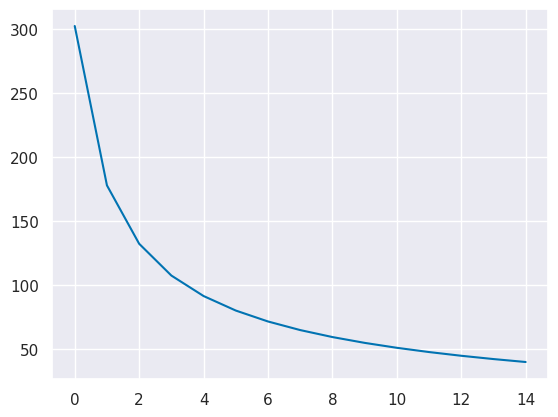

In [ ]:
print(z_i(sim, 0), z_i(sim, 1400))
z_list=[]
for i in range(0, 1401, 100):
    z_list.append(z_i(sim, i))

plt.plot(z_list)    

In [5]:
sim = SimDir('/home/jorge/Escritorio/Lic. Física/1Ramos/1Semestre X/Tesina/Toolkit/Simulations/testPert32MoreAmp/output-0000/')            
print(sim)

Indexed 23 files and 3 subdirectories
Folder /home/jorge/Escritorio/Lic. Física/1Ramos/1Semestre X/Tesina/Toolkit/Simulations/testPert32MoreAmp/output-0000
/home/jorge/Escritorio/Lic. Física/1Ramos/1Semestre X/Tesina/Toolkit/Simulations/testPert32MoreAmp/output-0000
Available scalar timeseries:
[]

Available minimum timeseries:
[]

Available maximum timeseries:
[]

Available norm1 timeseries:
[]

Available norm2 timeseries:
[]

Available average timeseries:
['betax', 'betay', 'betaz', 'kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'H', 'rho', 'gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz', 'M1', 'M2', 'M3', 'alp']
Variables available: dict_keys([])

Available grid data of dimension 1D (x): 
[]


Available grid data of dimension 1D (y): 
[]


Available grid data of dimension 1D (z): 
[]


Available grid data of dimension 2D (xy): 
[]


Available grid data of dimension 2D (xz): 
[]


Available grid data of dimension 2D (yz): 
[]


Available grid data of dimension 3D (xyz): 
['gxx', 'gxy', 'gxz', 'g

In [47]:
# Available iterations

avail_iter = sim.gf.xyz['kxx'].available_iterations 
print(f'{sim.gf.xyz['kxx'].available_iterations[:3]} ... {sim.gf.xyz['kxx'].available_iterations[-3:]}')

[0, 100, 200] ... [1200, 1300, 1400]


In [89]:
def plot_box_sufaces(box_size, var, iter, levels, title='NoTitle', figsize=(8, 6), save=False, filename='null'):
    '''plot outer and internal surfaces for the 3D distribution of a certain variable'''

    import matplotlib.ticker as mticker

    # Define dimensions
    #Nx, Ny, Nz = 32, 32, 32
    Nx, Ny , Nz = box_size, box_size, box_size
    X, Y, Z = np.meshgrid(np.linspace(-0.5, 0.5, Nx),
                          np.linspace(-0.5, 0.5, Ny),
                          np.linspace(-0.5, 0.5, Nz))

    # Create data
    data = var[iter][0][0]

    kw = {
        'vmin': data.min(),
        'vmax': data.max(),
        'levels': np.linspace(data.min(), data.max(), levels),          # Maybe 12 or 14
        'cmap' : 'inferno'
    }

    # Create a figure with 3D ax
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plot contour surfaces 
    ## Plot external surfaces

    ###   XY plane   ###
    xy_th=8                                           # threshold
    _ = ax.contourf(
        X[:xy_th, :, 0], Y[:xy_th, :, 0], data[:xy_th, :, 0],          # XY plane
        zdir='z', offset=Z.max(), **kw                  # This offset contrals position of the face
    )                                                   # Check if correct
    _ = ax.contourf(
        X[:, :xy_th, 0], Y[:, :xy_th, 0], data[:, :xy_th, 0],          
        zdir='z', offset=Z.max(), **kw                  
    ) 

    ###   XZ plane   ###
    xz_th=8
    _ = ax.contourf(
        X[0, :xz_th, :], data[0, :xz_th, :], Z[0, :xz_th, :],          # XZ plane
        zdir='y', offset=Y.max(), **kw          
    )
    _ = ax.contourf(
        X[0, :, :xz_th], data[0, :, :xz_th], Z[0, :, :xz_th],          # XZ plane
        zdir='y', offset=Y.max(), **kw 
    )

    ###   YZ plane   ###
    yz_th=8
    _ = ax.contourf(
        data[:yz_th, 0, :], Y[:yz_th, 0, :], Z[:yz_th, 0, :],       # YZ plane
        zdir='x', offset=X.max(), **kw
    )
    C = ax.contourf(
        data[:, 0, :yz_th], Y[:, 0, :yz_th], Z[:, 0, :yz_th],       # YZ plane
        zdir='x', offset=X.max(), **kw
    )


    ## Plot internal surfaces (still fine tunning)

    ###   YZ plane   ###
    yz_th_i = yz_th - 1 
    offset2 = -0.26
    _ = ax.contourf(
        data[yz_th_i:, yz_th, yz_th_i:], Y[yz_th_i:, yz_th, yz_th_i:], Z[yz_th_i:, yz_th, yz_th_i:],       # YZ plane
        zdir='x', offset=offset2, **kw
    )
    ###   XZ plane   ###
    xz_th_i = xz_th - 1
    _ = ax.contourf(
        X[xz_th, xz_th_i:, xz_th_i:], data[xz_th, xz_th_i:, xz_th_i:], Z[xz_th, xz_th_i:, xz_th_i:],          # XZ plane
        zdir='y', offset=offset2, **kw          
    )

    ###   XY plane   ###
    xy_th_i = xy_th -1 
    _ = ax.contourf(
        X[xy_th_i:, xy_th_i:, xy_th], Y[xy_th_i:, xy_th_i:, xy_th], data[xy_th_i:, xy_th_i:, xy_th],          
        zdir='z', offset=offset2, **kw                  
    ) 


    # Set limits of the plot from coord limits
    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()
    zmin, zmax = Z.min(), Z.max()
    ax.set(xlim=[xmin, xmax+0.1], ylim=[ymin, ymax+0.1], zlim=[zmin, zmax+0.1])

    # Plot edges
    edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
    #ax.plot([xmax, xmax], [ymin, ymax+5], 0, **edges_kw)
    #ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
    #ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

    # Set labels and ticks
    ax.set(
        xlabel=r'x [$\lambda_{\text{pert}}$]',
        ylabel=r'y [$\lambda_{\text{pert}}$]',
        zlabel=r'z [$\lambda_{\text{pert}}$]',
        xticks=[-0.5, -0.25, 0.0, 0.25, 0.5],      # First fix the coordinates
        yticks=[-0.5, -0.25, 0.0, 0.25, 0.5],
        zticks=[-0.5, -0.25, 0.0, 0.25, 0.5],
    )

    # Set zoom and angle view
    ax.view_init(elev=25, azim=35, roll=0)
    ax.set_box_aspect(None)

    # Colorbar
    #fig.colorbar(C, ax=ax, fraction=0.02, pad=0.04)
    #fig.colorbar(C, ax=ax, fraction=0.02, pad=0.04, extend='min')

    rho_ticks = [str(i/100) for i in range(-2, 4)]
    fig.colorbar(C, ax=ax, 
                ticks=list(np.linspace(0.04352,0.06847, 6)),
                format=mticker.FixedFormatter(rho_ticks),
                extend='max',
                fraction=0.02, 
                pad=0.04)           
    
    plt.title(f'{title} at z = {round(z_i(sim, iter),2)}')           # 
    # Show Figure
    
    if save: 
        plt.savefig(f"{filename}.png", dpi=400)
    plt.show()


In [ ]:
def plot_z_slice(var, i, z, var_name):
    slice = var[i][0][0][:, :, z]
    plt.imshow(slice, origin="lower", cmap="inferno")
    plt.colorbar(label=var_name)
    plt.xlabel('x') 
    plt.ylabel('y')

    redshift = round(z_i(sim, i),2)
    plt.title(f'{var_name}  | iter= {i}  | z= {redshift}  | z_lev= {z}')

# No labels, for subplot
def plot_z_slice_clean(var, i, z, var_name, norm=False):
    '''plot a z_slice of a variable, at a certain iteration, optionally u can normalize the colorbar'''

    slice = var[i][0][0][:, :, z]
    if not norm:
        plt.imshow(slice, origin="lower", cmap="inferno")
        plt.colorbar(shrink=.5)
        #plt.xlabel('x')
        #plt.ylabel('y')
    
        redshift = round(z_i(sim, i),2)
        plt.title(f'{var_name} | it{i} | z{redshift} | z_lev{z}', fontsize=13)  

    if norm:
        vmin = var[i].min()             # normalize colorbar w.r.t. that particular iteration
        vmax = var[i].max()
        plt.imshow(slice, origin="lower", cmap="inferno", vmin=vmin, vmax=vmax)
        plt.colorbar(shrink=.5)
        #plt.xlabel('x')
        #plt.ylabel('y')
    
        redshift = round(z_i(sim, i),2)
        plt.title(f'{var_name} | it{i} | z{redshift} | z_lev{z}', fontsize=13)  


# Develop a more general plotting function to be able to slice in other directions    

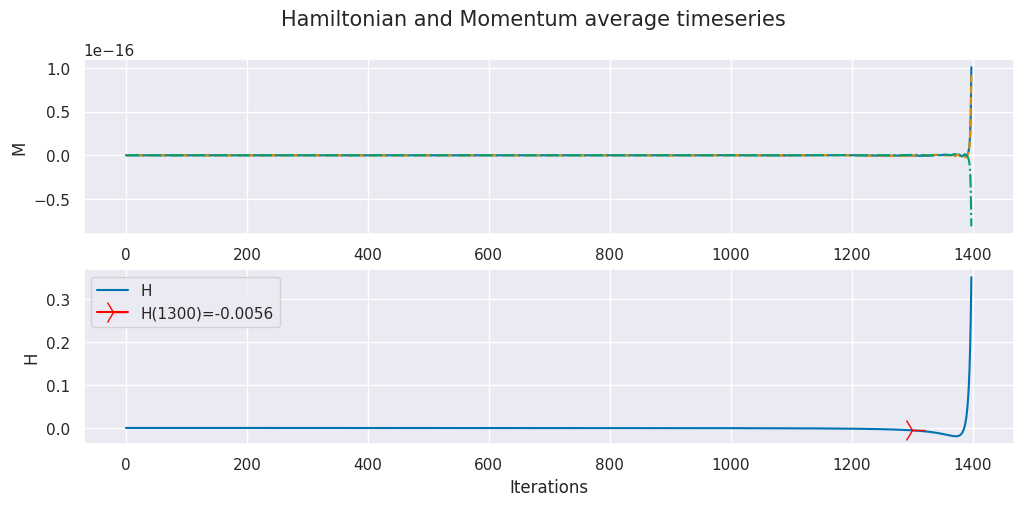

In [28]:
M1 = sim.timeseries.average['M1']
M2 = sim.timeseries.average['M2']
M3 = sim.timeseries.average['M3']
H  = sim.timeseries.average['H']

li=12
plt.figure(figsize=(12,5))
plt.suptitle("Hamiltonian and Momentum average timeseries", fontsize=15)
plt.subplot(2,1,1)
plt.plot(M1.y[:-li], label='M1')
plt.plot(M3.y[:-li], label='M2', linestyle='--')
plt.plot(M2.y[:-li], label='M3', linestyle='-.')
plt.ylabel('M')
#plt.legend()

n=1300
H_n = round(H.y[n],4)
plt.subplot(2,1,2)
plt.plot(H.y[:-li], label='H')
plt.plot(n, H.y[n], label=f'H({n})={H_n}', color="red", marker="4", markersize=18)
plt.xlabel('Iterations')
plt.ylabel('H')
plt.legend()

# Grid Functions

In [30]:
# Define grid functions

kxx, gxx = sim.gf.xyz['kxx'], sim.gf.xyz['gxx']               # sim.gf.dim['var'][iteration]
kxy, gxy = sim.gf.xyz['kxy'], sim.gf.xyz['gxy']
kxz, gxz = sim.gf.xyz['kxz'], sim.gf.xyz['gxz']
kyy, gyy = sim.gf.xyz['kyy'], sim.gf.xyz['gyy']
kyz, gyz = sim.gf.xyz['kyz'], sim.gf.xyz['gyz']
kzz, gzz = sim.gf.xyz['kzz'], sim.gf.xyz['gzz']

rho = sim.gf.xyz['rho']

## z-slices

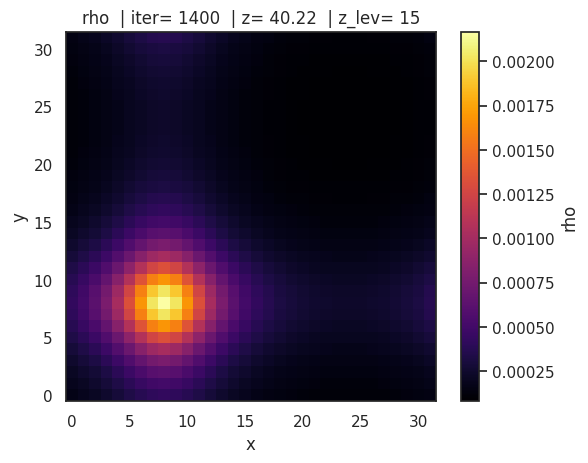

In [59]:
# z_slices

plot_z_slice(var=rho, i=1400, z=15, var_name='rho')

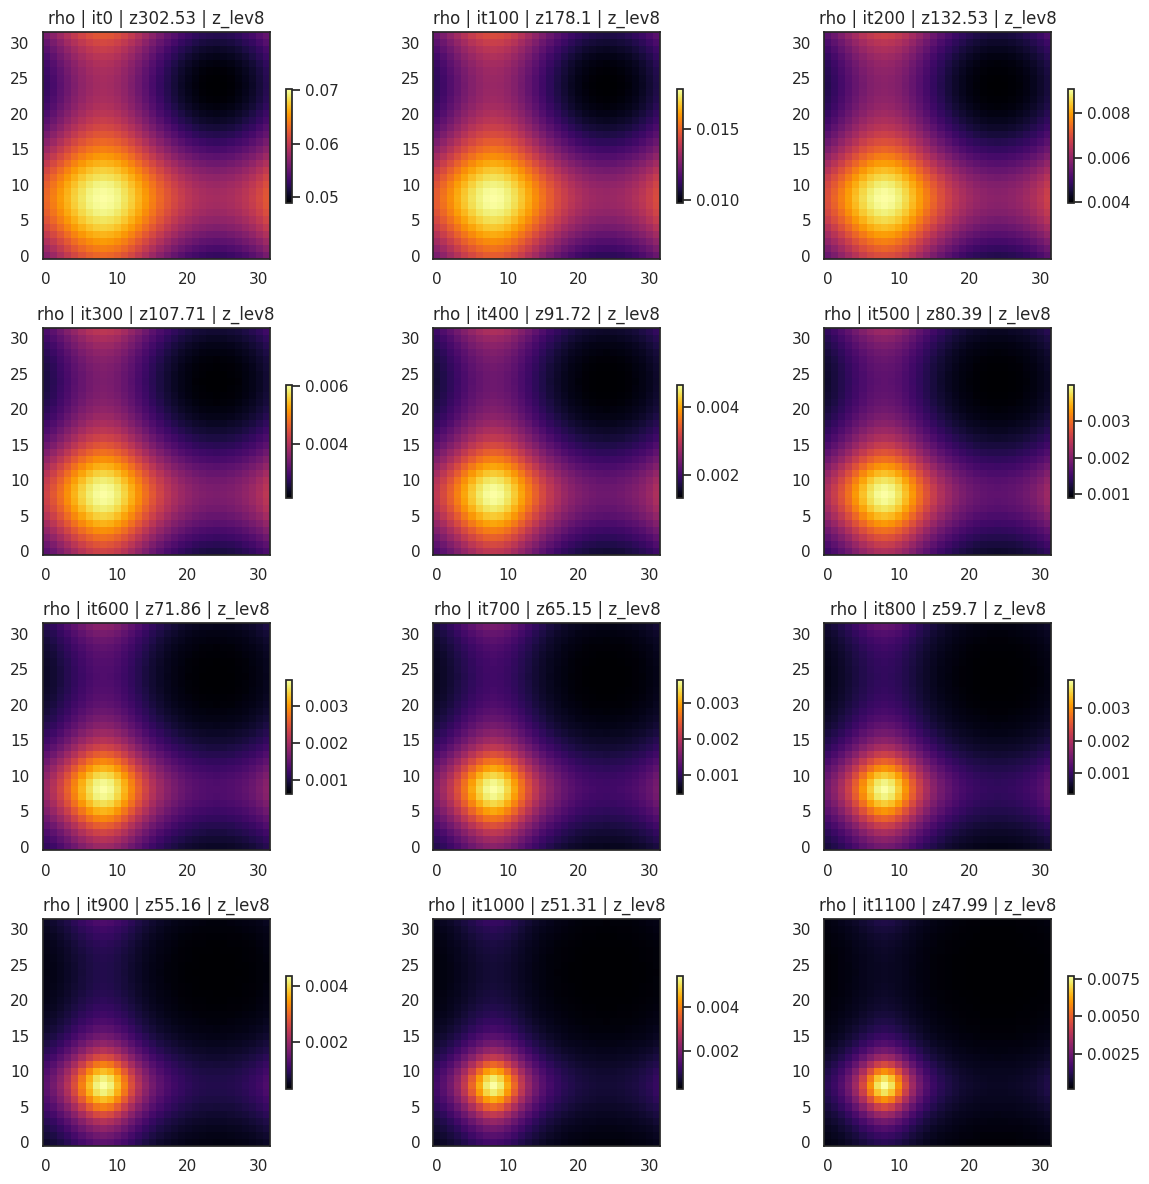

In [ ]:
# Fix z_level, different iterations

plt.figure(figsize=(12,12))
sns.set_style("white") 
for j in range(12):
    plt.subplot(4,3,j+1)
    plot_z_slice_clean(var=rho, i=avail_iter[j], z=8, var_name='rho')

plt.tight_layout()    

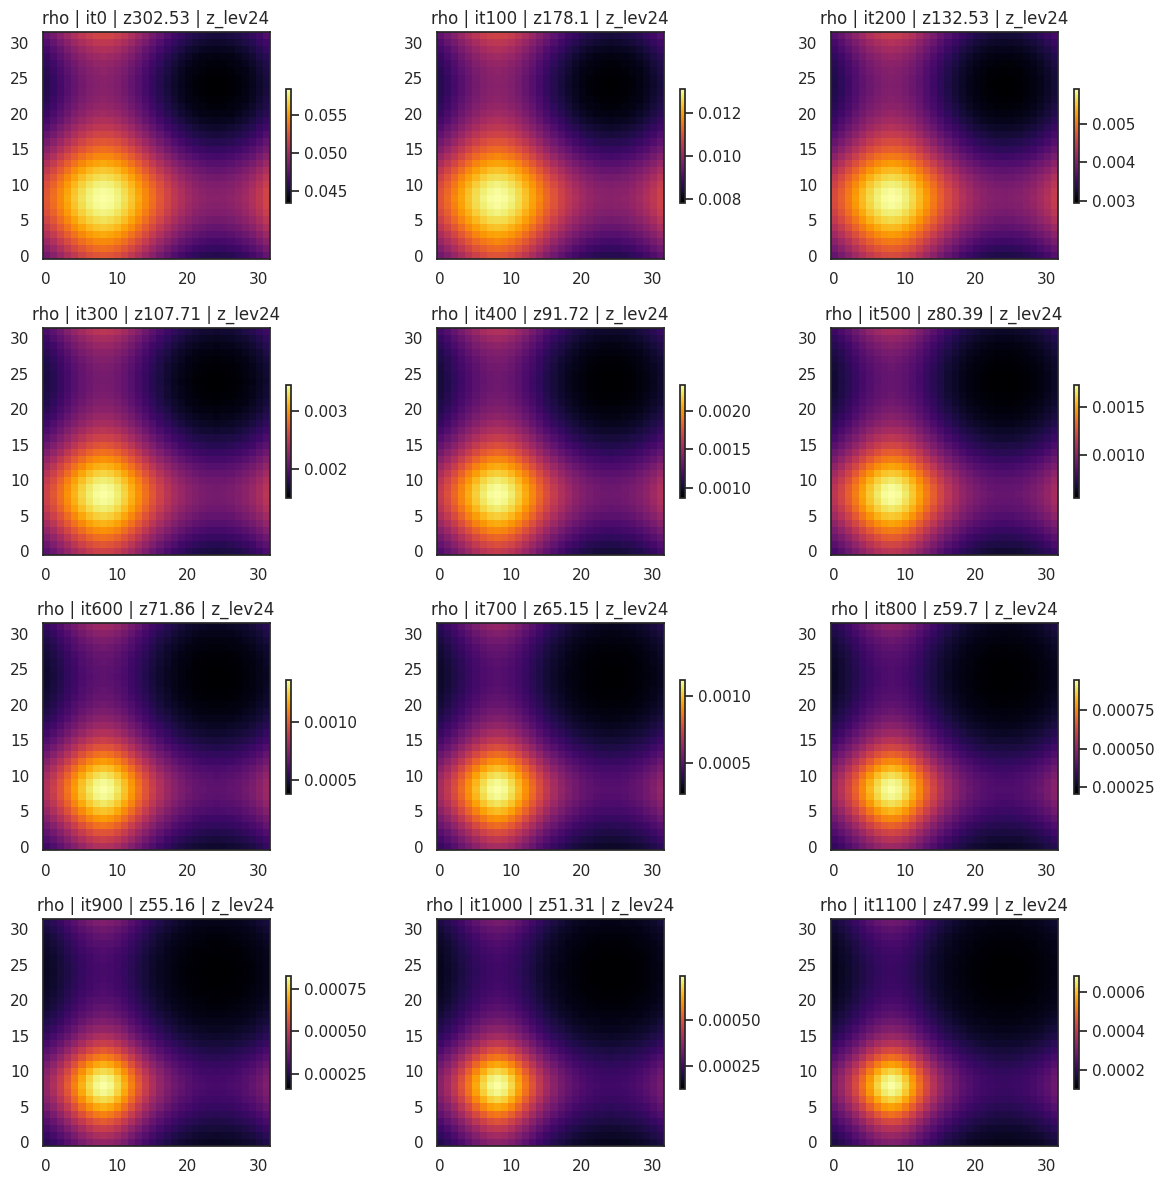

In [ ]:
# # Fix z_level, different iterations

plt.figure(figsize=(12,12))
sns.set_style("white") 
for j in range(12):
    plt.subplot(4,3,j+1)
    plot_z_slice_clean(var=rho, i=avail_iter[j], z=32-8, var_name='rho')

plt.tight_layout()    

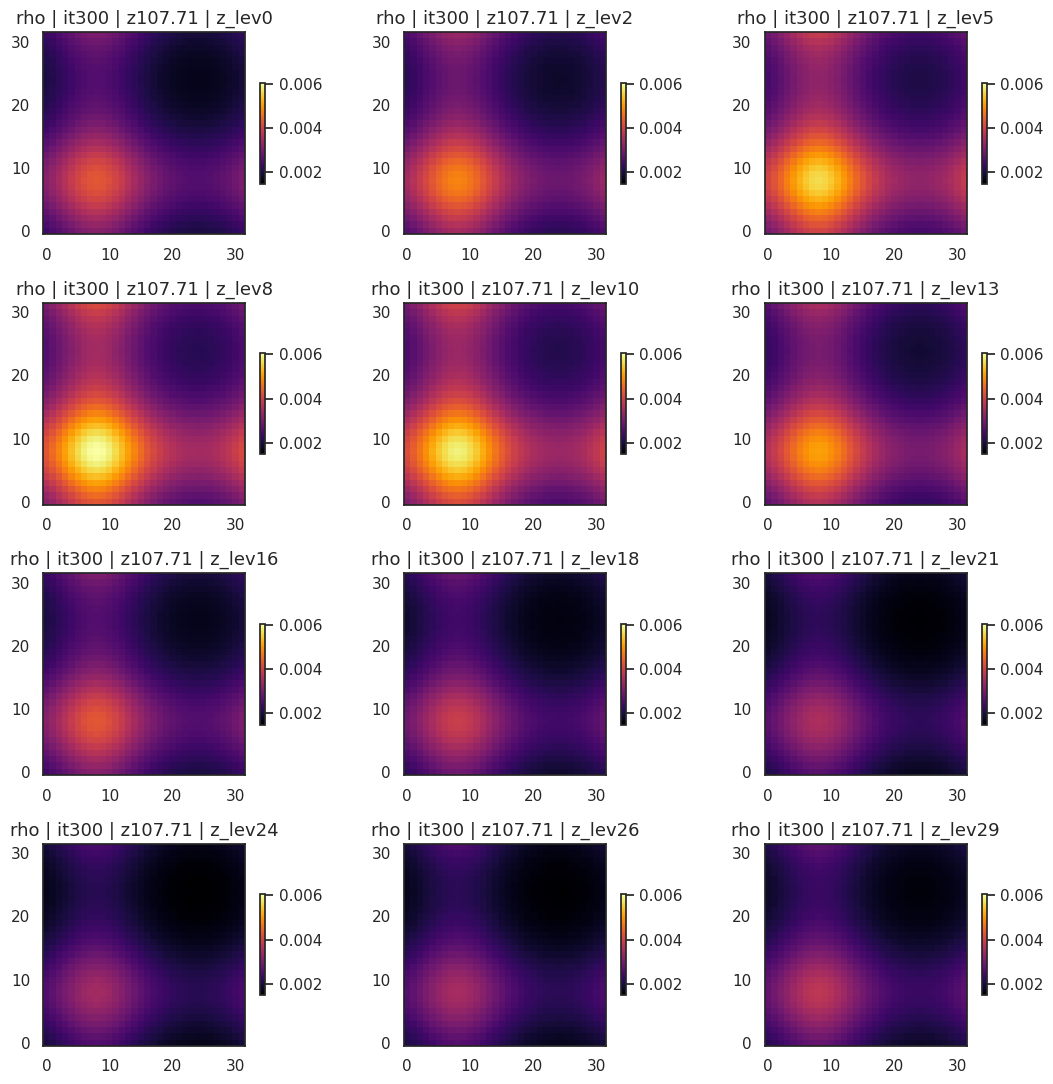

In [68]:
# Fix iteration, different z-levels

iteration=300

plt.figure(figsize=(11,11))
sns.set_style("white") 
for j in range(12):
    plt.subplot(4,3,j+1)
    plot_z_slice_clean(var=rho, i=iteration, z=j*32//12, var_name='rho', norm=True)

plt.tight_layout()  

**Note**: the normalization of the colorbar is gonna be useful only for visualizing the same iteration 

## Box-surfaces plots

<Figure size 700x700 with 0 Axes>

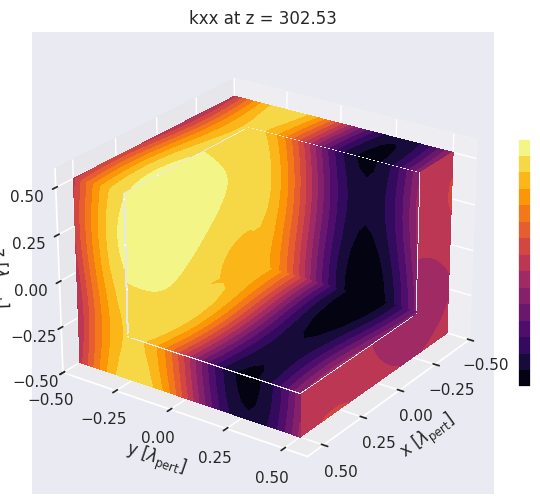

In [76]:
sns.set_theme(context='notebook', style='darkgrid', palette='colorblind')
plt.figure(figsize=(7,7))
plot_box_sufaces(box_size=32, var=kxx, iter=0, levels=16, title='kxx', figsize=(8, 6))

<Figure size 700x700 with 0 Axes>

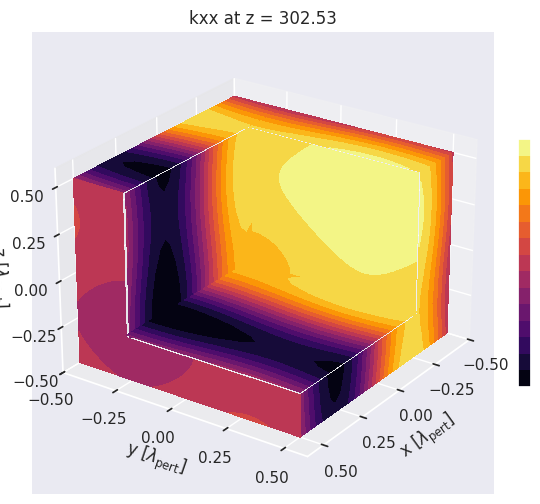

In [ ]:
sns.set_theme(context='notebook', style='darkgrid', palette='colorblind')
plt.figure(figsize=(7,7))
plot_box_sufaces(box_size=32, var=kyy, iter=0, levels=16, title='kyy', figsize=(8, 6))

ValueError: Contour levels must be increasing

<Figure size 700x700 with 0 Axes>

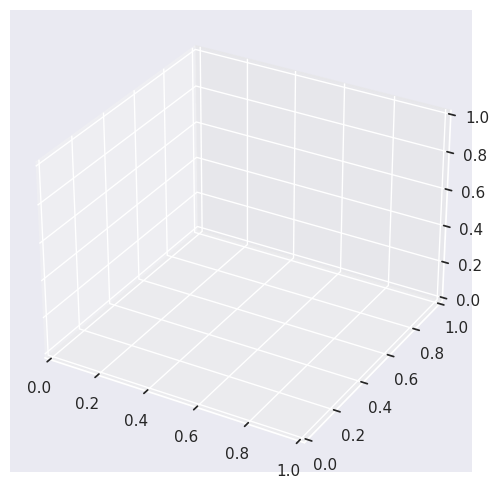

In [ ]:
#sns.set_theme(context='notebook', style='darkgrid', palette='colorblind')
#plt.figure(figsize=(7,7))
#plot_box_sufaces(box_size=32, var=kxy, iter=0, levels=16, title='kxy', figsize=(8, 6))

# Failed due to all zeros 
kxy[0][0][0][0].max()

<Figure size 700x700 with 0 Axes>

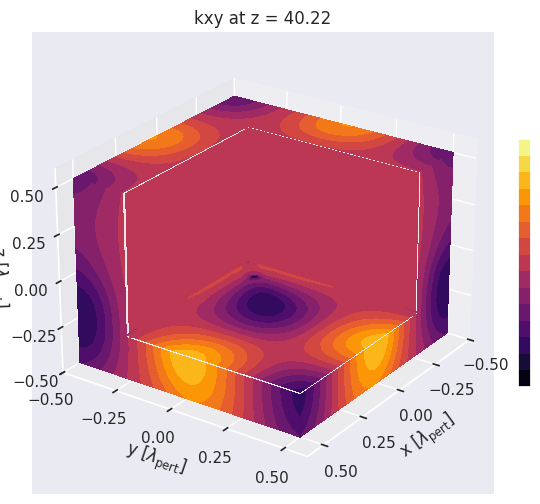

In [94]:
sns.set_theme(context='notebook', style='darkgrid', palette='colorblind')
plt.figure(figsize=(7,7))
plot_box_sufaces(box_size=32, var=kxy, iter=1400, levels=16, title='kxy', figsize=(8, 6), save=True, filename='k1400')